In [1]:
import sys,os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [3]:
d_crime=pd.read_csv('LAPD_crime.csv')
print d_crime.shape
d_crime.head(1)

(228017, 7)


,date,time,area,status,address,location,crime
0,12/2/2015 0:00,150,Central,Invest Cont,400 S LOS ANGELES ST,"(34.0473, -118.2462)",OTHER


In [4]:
date=pd.to_datetime(d_crime['date'])
print date.min()
print date.max()
t_delta=(date-date.min()).astype('timedelta64[D]')
d_crime['days']=t_delta
d_crime.head(1)

2015-01-01 00:00:00
2015-12-02 00:00:00


,date,time,area,status,address,location,crime,days
0,12/2/2015 0:00,150,Central,Invest Cont,400 S LOS ANGELES ST,"(34.0473, -118.2462)",OTHER,335


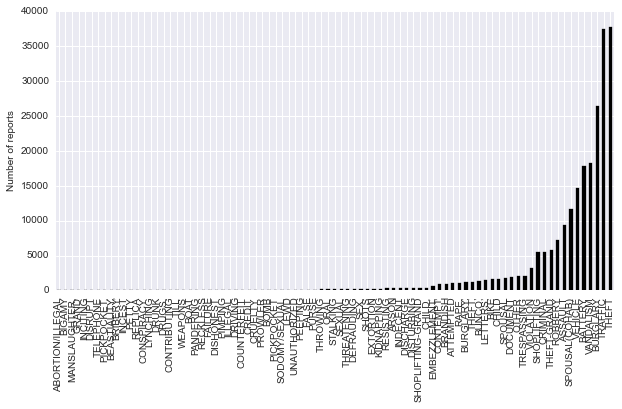

In [10]:
def plotdat(data,cat):
    l=data.groupby(cat).size()
    l.sort()
    fig=plt.figure(figsize=(10,5))
    plt.yticks(fontsize=8)
    l.plot(kind='bar',fontsize=10,color='k')
    plt.xlabel('')
    plt.ylabel('Number of reports',fontsize=10)

plotdat(d_crime,'crime')

In [7]:
l=d_crime.groupby('crime').size()
l.sort()
print l.shape

(85,)


In [9]:
def types_districts(d_crime,per):
    
    # Group by crime type and district 
    hoods_per_type=d_crime.groupby('crime').area.value_counts(sort=True)
    t=hoods_per_type.unstack().fillna(0)
    
    # Sort by hood sum
    hood_sum=t.sum(axis=0)
    hood_sum.sort(ascending=False)
    t=t[hood_sum.index]
    
    # Filter by crime per district
    crime_sum=t.sum(axis=1)
    crime_sum.sort()
    
    # Large number, so let's slice the data.
    p=np.percentile(crime_sum,per)
    ix=crime_sum[crime_sum>p]
    t=t.loc[ix.index]
    return t
    
t=types_districts(d_crime,96)

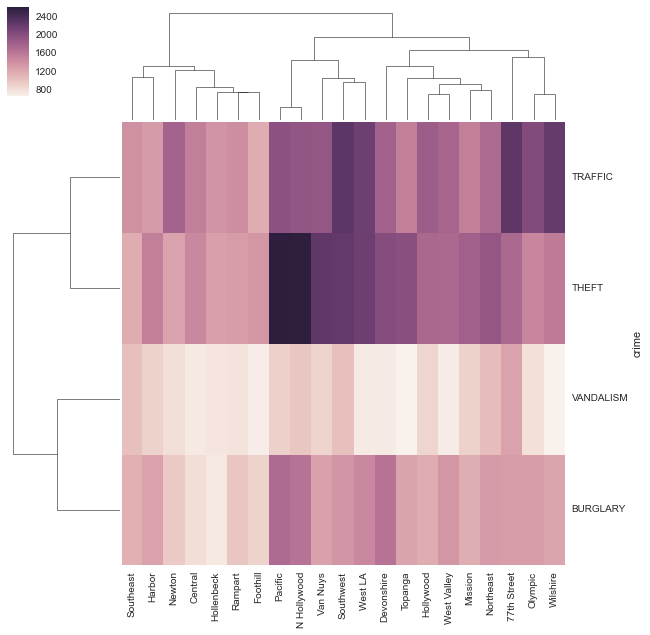

In [11]:
sns.clustermap(t)

Some notes on the heatmap:
* There are more thefts and burglary in the Pacific and North Hollywood area than anywhere else. But there doesn't seem to be a lot of vandalism in those areas. 77th street area takes that spot. 
* There are lot of traffic violations at Olympic and Wilshire.
* The Hollenbeck area has the fewest number of major crimes on all counts.

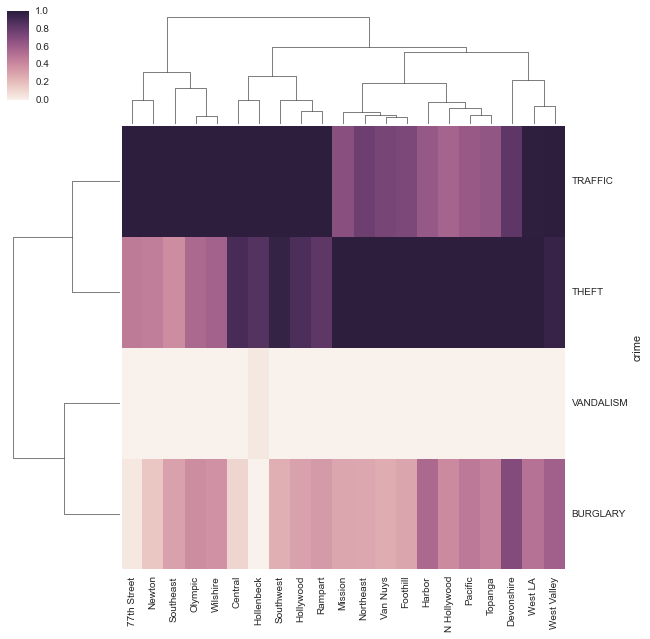

In [12]:
sns.clustermap(t,standard_scale=1)

The above normalizes the distribution across all districts

Let's say we want to track where in Los Angeles there are high rates of vandalism

In [17]:
# drill down to arson
cat=d_crime[d_crime['crime']=='VANDALISM']
c=cat['area'].value_counts()
c.sort(ascending=False)
c.head(10)

77th Street    1274
Northeast      1076
Southwest      1061
Southeast      1058
N Hollywood    1008
Pacific         931
Mission         928
Harbor          927
Van Nuys        913
Hollywood       893
dtype: int64

What if we want to know when these vandalism crimes usually take place?

In [18]:
# drill down to arson
cat=d_crime[d_crime['crime']=='VANDALISM']
c=cat['time'].value_counts()
c.sort(ascending=False)
c.head(10)

2000    720
2200    716
1800    689
2100    666
1900    641
1700    543
1200    537
2300    484
1600    427
1500    405
dtype: int64

The left column is in military time. Most crimes are aggregating around the 1800 to 2300 range. This time, not suprisingly, is 6:00 pm to 11:00 pm. Vandalism tends to be reported in the evenings. 

In [19]:
t=types_districts(cat,70)

In [22]:
# Let's drill down onto one
cat=d_crime[d_crime['crime']=='VANDALISM']

# Bin crime by 30 day window
cat['Month']=np.floor(cat['days']/30) # Approximate month (30 day window)

# Default
district='All'

/Users/jmolayem/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [24]:
def timeseries(dat,per):
    ''' Category grouped by month '''
    
    # Group by crime type and district 
    cat_per_time=dat.groupby('Month').crime.value_counts(sort=True)
    t=cat_per_time.unstack().fillna(0)
        
    # Filter by crime per district
    crime_sum=t.sum(axis=0)
    crime_sum.sort()
    
    # Large number, so let's slice the data.
    p=np.percentile(crime_sum,per)
    ix=crime_sum[crime_sum>p]
    t=t[ix.index]
    return t
    
t_all=timeseries(cat,0)